# An Analysis of UK Household Finances using the BoE/NMG Annual Household Survey 2011-2023

## Introduction


## Set-up

In [76]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [145]:
# Read data
excel_file = "boe-nmg-household-survey-data.xlsx"
all_sheets = pd.read_excel(excel_file, sheet_name=None)

# Concatenate sheets into a single df
exclude_sheets = ["Instructions", "Data description", "2011-2023 PID-SUBSID"] 
combined_df = pd.concat(
    [df.assign(year=sheet_name) for sheet_name, df in all_sheets.items() if sheet_name not in exclude_sheets],
    ignore_index=True
)
combined_df['year'] = pd.to_datetime(combined_df['year'], format='%Y')
combined_df.head()

,we_factor,subsid,dsoc,dsocial,fgenage_1,dage,dregion,fgen,qhousing,dhousing,...,spq14d_rank_2,spq14d_rank_3,spq14d_rank_4,spq14d_rank_970,boe93_1,boe93_2,boe93_3,boe93_4,boe93_5,boe93_na
0,1.176425,22007620.0,2.0,1.0,23,1,3,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.931040,22238715.0,5.0,5.0,22,1,3,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.181808,20404925.0,2.0,1.0,59,5,3,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000213,21839916.0,5.0,5.0,21,1,9,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.913671,23091998.0,4.0,4.0,24,1,1,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# Read inflation data
inflation_df = pd.read_csv("inflation-2011-2023.csv")
inflation_df = inflation_df.rename(columns={'Title': 'date', 'CPIH ANNUAL RATE 00: ALL ITEMS 2015=100': 'cpih_annual_rate'}).copy()
inflation_df['date'] = pd.to_datetime(inflation_df['date'], format='%Y %b')
# Filter for years 2011 to 2023 to align with survey data
start_date = pd.to_datetime('2011-01-01')
end_date = pd.to_datetime('2023-12-31')
inflation_df = inflation_df[(inflation_df['date'] >= start_date) & (inflation_df['date'] <= end_date)].reset_index(drop=True).copy()
# Sort
inflation_df = inflation_df.sort_values(by='date', ascending=False).reset_index(drop=True).copy()

inflation_df.head(5)

,date,cpih_annual_rate
0,2023-12-01,4.2
1,2023-11-01,4.2
2,2023-10-01,4.7
3,2023-09-01,6.3
4,2023-08-01,6.3


In [163]:
# Read interest rate data
interest_df = pd.read_csv("bank-rate.csv")
interest_df = interest_df.rename(columns={'Date Changed': 'date', 'Rate': 'bank_rate'}).copy()
interest_df['date'] = pd.to_datetime(interest_df['date'], format='%d %b %y')
# Filter for years 2011 to 2023 to align with survey data
interest_df = interest_df[(interest_df['date'] >= start_date) & (interest_df['date'] <= end_date)].reset_index(drop=True).copy()
# Add value for 01-01-2011 to ensure data can be plotted all the way back
new_row = {'date': pd.to_datetime('2011-01-01'), 'bank_rate': 0.25}
interest_df = pd.concat([interest_df,pd.DataFrame([new_row])], ignore_index=True).copy()

interest_df.head(25)

,date,bank_rate
0,2023-08-03,5.25
1,2023-06-22,5.00
2,2023-05-11,4.50
3,2023-03-23,4.25
4,2023-02-02,4.00
5,2022-12-15,3.50
6,2022-11-03,3.00
7,2022-09-22,2.25
8,2022-08-04,1.75
9,2022-06-16,1.25


## Data Processing

### Understanding the availability of data
This section seeks to understand the availability of different data fields across the span of the period of the study. 

In [65]:
def count_blanks_and_non_blanks(fields: list):
    """
    Counts the number of blank and non-blank values for each column in the input list, grouped by 'year'.

    Parameters:
        fields (list): List of column names to analyze.
    """
    for field in fields:
        if field not in combined_df.columns:
            print(f"Column '{field}' not found in the DataFrame. Skipping...")
            continue  # Skip to the next column
        
        print(f"\nSummary for {field}:\n")
        
        blank_non_blank_summary = combined_df.groupby('year')[field].apply(
            lambda x: pd.Series({
                'Blanks': x.isnull().sum(),
                'Non-Blanks': x.notnull().sum()
            })
        ).unstack()

        # Display results
        print(blank_non_blank_summary)

In [75]:
# Availability of demographic data
#   - dage : age (single band)
#   - fgenage_1 : age (free)
#   - fgen : gender (single band)
#   - qregion : region in UK (single band) (more detail than dregion)
#   - dregion : region in UK (single band)
#   - qual : highest educational attainment (single band)
#   - nochildren : number of children (free: int)
demograph_fields = ['dage', 'fgenage_1', 'fgen', 'qregion', 'dregion', 'qual', 'nochildren']
count_blanks_and_non_blanks(demograph_fields)


Summary for dage:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015       0        6007
2016       0        6011
2017       0        6018
2018       0        6000
2019       0        6051
2020       0        6032
2021       0        6051
2022       0        6053
2023       0        5914

Summary for fgenage_1:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015       0        6007
2016       0        6011
2017       0        6018
2018       0        6000
2019       0        6051
2020       0        6032
2021       0        6051
2022       0        6053
2023       0        5914

Summary for fgen:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015       0        6007
2016      

In [66]:
# Availability of income data
#   - qincome : gross household income (single band)
#   - qincomev1 : gross household income (single band) (same as above)
#   - qincomev2 : gross income per individual in household (single band)
#   - qbe01 : 'disposable' income (single band) 
#   - qbe01free_1 : 'disposable' income (free) 
#   - mthincome : combined household monthly income (single band)
#   - overallincomecomb : overal combined household income (single band)
income_fields = ['qincome', 'qincomev1', 'qincomev2_1_3', 'qincomefreev2_n_3', 'mthincome', 'overallincomecomb', 'qbe01', 'qbe01free_1']
count_blanks_and_non_blanks(income_fields)


Summary for qincome:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015    6007           0
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021    6051           0
2022    6053           0
2023    5914           0

Summary for qincomev1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    2877        3130
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021    6051           0
2022    6053           0
2023    5914           0

Summary for qincomev2_1_3:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    5567         44

In [71]:
# Availability of savings data
#   - be2a : monthly savings (single band)
#   - be2afree_1 : monthly savings (free) (also be2afree_c)
#   - soa1 : change in monthly savings over past year (single band)
#   - soa1b : reason behind change in monthly savings IF DECREASE (multi band)
#   - soa1c : reason behind change in monthly savings IF INCREASE (multi band)

savings_fields = ['be2a', 'be2afree_1', 'soa1']
count_blanks_and_non_blanks(savings_fields)


Summary for be2a:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015       0        6007
2016       0        6011
2017       0        6018
2018       0        6000
2019       0        6051
2020       0        6032
2021       0        6051
2022       0        6053
2023       0        5914

Summary for be2afree_1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    3280        2726
2014    1976        4025
2015    2144        3863
2016    2457        3554
2017    2379        3639
2018    2689        3311
2019    2506        3545
2020    2733        3299
2021    2482        3569
2022    2389        3664
2023    2292        3622

Summary for soa1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    6007           0
2016    6

In [70]:
# Availability of spending data
#   - boe56 : cost of bills (single band)
#   - BOE56free : cost of bills (free)

spending_fields = ['boe56', 'BOE56free_1']
count_blanks_and_non_blanks(spending_fields)


Summary for boe56:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014     896        5105
2015    6007           0
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021    6051           0
2022    6053           0
2023    5914           0

Summary for BOE56free_1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    2404        3597
2015    6007           0
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021    6051           0
2022    6053           0
2023    5914           0


In [72]:
# Availability of housing data
#   - be04 : house value (single band)
#   - be04free_1 : house value (free) (also be04free_c)
#   - qhousing : housing type (single band) (more detail than dhousing)
#   - dhousing : housing type (single band) 
#   - be44 : type of mortage (multi band) 
#   - be07 : amount left to pay on mortgage (single band) 
#   - be07free : amount left to pay on mortgage (free)
#   - mh01 : taken mortgage payment holiday this year? (single band) 
#   - be08 : value of last monthly payment on mortgage (single band) 
#   - be08free : value of last monthly payment on mortgage (single band) (also be08free_c)
#   - overallbe08 : overall monthly mortgage installment (single band)
#   - boe47 : interest rate on mortgage (single band)

housing_fields = ['be04', 'be04free_1', 'qhousing', 'dhousing', 'be44', 'be07', 'be07free_1', 'mh01', 'be08', 'be08free_1', 'overallbe08', 'boe47']
count_blanks_and_non_blanks(housing_fields)


Summary for be04:

      Blanks  Non-Blanks
year                    
2011     629         366
2012    2753        1250
2013    4153        1853
2014    3423        2578
2015    4228        1779
2016    4281        1730
2017    4416        1602
2018    4181        1819
2019    4243        1808
2020    4299        1733
2021    4303        1748
2022    2271        3782
2023    2278        3636

Summary for be04free_1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    5008         998
2014    3929        2072
2015    4588        1419
2016    4731        1280
2017    4827        1191
2018    4709        1291
2019    4683        1368
2020    4649        1383
2021    4743        1308
2022    3185        2868
2023    3046        2868

Summary for qhousing:

      Blanks  Non-Blanks
year                    
2011       0         995
2012       0        4003
2013       0        6006
2014       0        6001
2015       0        6007
2016 

In [73]:
# Availability of market expectations data
# - boe39a_1 : expected BoE interest rate in 1 years time (single band)
# - boe39a_2 : expected BoE interest rate in 2 years time (single band)
# - boe39a_3 : expected BoE interest rate in 5 years time (single band)
market_fields = ['boe39a_1', 'boe39a_2', 'boe39a_3']
count_blanks_and_non_blanks(market_fields)


Summary for boe39a_1:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    6007           0
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021       0        6051
2022       0        6053
2023       0        5914

Summary for boe39a_2:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    6007           0
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021       0        6051
2022       0        6053
2023       0        5914

Summary for boe39a_3:

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    6006           0
2014    6001           0
2015    6007           0
201

### Data transformation

Midpoint imputations

In [151]:
# Midpoint imputations - generally greater response rate for banded than free-text responses
def calc_band_midpoint(band_column: str, band_mapping: dict):
    """
    Calculate the midpoint for a band based on its associated numeric value.
    """
    return band_mapping.get(band_column, np.nan)

In [152]:
# Income
# mthincome - monthly gross income per household
mthincome_band_mapping = {
    0: -1,                        # less than £0
    1: 0,                         # £0
    2: 104.5,                     # £1 to £208
    3: 291.5,                     # £208 to £375
    4: 458.5,                     # £375 to £542
    5: 583.5,                     # £542 to £625
    6: 708.5,                     # £625 to £792
    7: 875.0,                     # £792 to £958
    8: 1041.5,                    # £958 to £1125
    9: 1208.5,                    # £1125 to £1292
    10: 1375.0,                   # £1292 to £1458
    11: 1770.5,                   # £1458 to £2083
    12: 2500.0,                   # £2083 to £2917
    13: 3333.5,                   # £2917 to £3750
    14: 4166.5,                   # £3750 to £4583
    15: 5416.5,                   # £4583 to £6250
    16: 7291.5,                   # £6250 to £8333
    17: 8333,                     # £8333 or more
    18: np.nan                    # Don't know/Not stated
}

combined_df['x_mthincome_midpoint'] = combined_df['mthincome'].apply(calc_band_midpoint, band_mapping=mthincome_band_mapping)
# Calc annual income from monthly value
combined_df['x_annual_income'] = combined_df['x_mthincome_midpoint']*12

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_1411/2960754470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_mthincome_midpoint'] = combined_df['mthincome'].apply(calc_band_midpoint, band_mapping=mthincome_band_mapping)
/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_1411/2960754470.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_annual_income'] = combined_df['x_mthincome_midpoint']*12


In [153]:
# Savings
be2a_band_mapping = {
    1: 0,                        # None
    2: 12.5,                     # £1 - £24
    3: 37.0,                     # £25-£49
    4: 74.5,                     # £50-£99
    5: 124.5,                    # £100 - £149
    6: 174.5,                    # £150 - £199
    7: 224.5,                    # £200 - £249
    8: 274.5,                    # £250 - £299
    9: 324.5,                    # £300 - £349
    10: 374.5,                   # £350 - £399
    11: 424.5,                   # £400 - £449
    12: 474.5,                   # £450 - £499
    13: 549.5,                   # £500 - £599
    14: 649.5,                   # £600 - £699
    15: 749.5,                   # £700 - £799
    16: 849.5,                   # £800 - £899
    17: 949.5,                   # £900 - £999
    18: 1249.5,                  # £1,000 - £1,499
    19: 1749.5,                  # £1,500 - £1,999
    20: 2000,                    # £2,000 or more
    97: np.nan,                  # Don’t know
    96: np.nan                   # Prefer not to state
}

# Apply the function to calculate midpoints
combined_df['x_be2a_midpoint'] = combined_df['be2a'].apply(calc_band_midpoint, band_mapping=be2a_band_mapping)
# Calc annual savings from monthly value
combined_df['x_annual_savings'] = combined_df['x_be2a_midpoint']*12


/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_1411/2267761856.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_be2a_midpoint'] = combined_df['be2a'].apply(calc_band_midpoint, band_mapping=be2a_band_mapping)
/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_1411/2267761856.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_annual_savings'] = combined_df['x_be2a_midpoint']*12


## Summary Trends - income, saving and amrket conditions

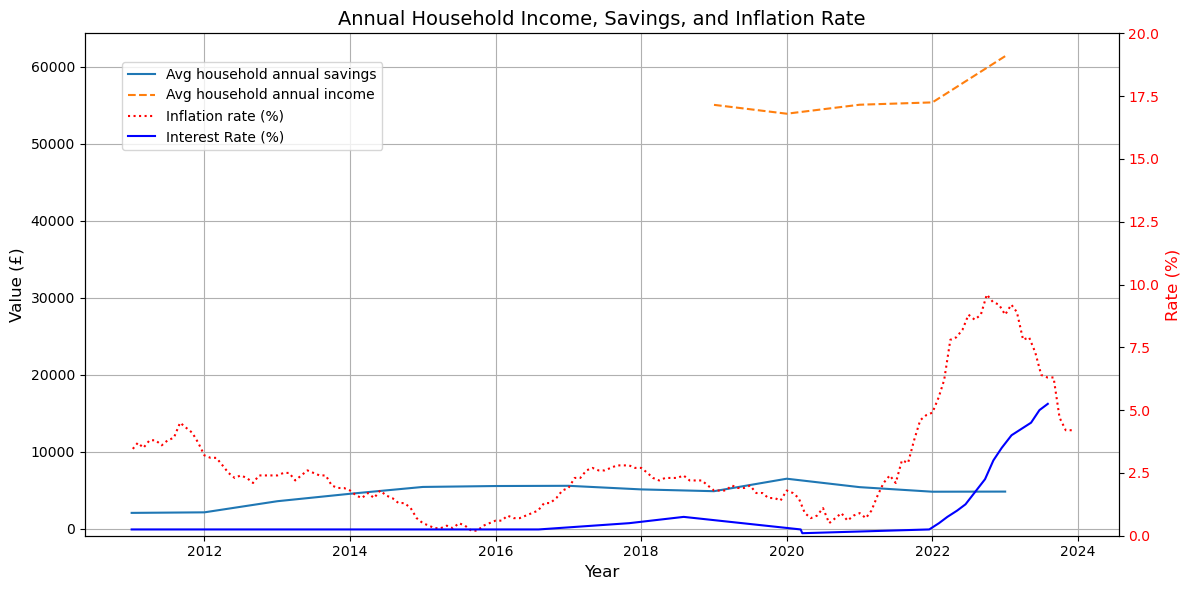

In [183]:
average_savings_per_year = combined_df.groupby('year')['x_annual_savings'].mean()
average_income_per_year = combined_df.groupby('year')['x_annual_income'].mean()

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average savings and income on the primary y-axis
ax1.plot(average_savings_per_year.index, average_savings_per_year.values, marker='', linestyle='-', label='Avg household annual savings')
ax1.plot(average_income_per_year.index, average_income_per_year.values, marker='', linestyle='--', label='Avg household annual income')


# Set labels for the primary y-axis
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Value (£)', fontsize=12)
ax1.tick_params(axis='y')

# Add a secondary y-axis for inflation and interest rate
ax2 = ax1.twinx()
ax2.plot(inflation_df['date'], inflation_df['cpih_annual_rate'], marker='', linestyle=':', color='red', label='Inflation rate (%)')
ax2.plot(interest_df['date'], interest_df['bank_rate'], marker='', linestyle='-', color='blue', label='Interest Rate (%)')
ax2.set_ylim(0, 20)


# Set labels for the secondary y-axis
ax2.set_ylabel('Rate (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Add a title
plt.title('Annual Household Income, Savings, and Inflation Rate', fontsize=14)

# Add grid
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Housing

In [18]:
combined_df.groupby('year')['dhousing'].value_counts()

year  dhousing
2011  1            382
      2            344
      4            131
      3            123
      98            15
                  ... 
2023  2           2180
      1           1600
      4           1051
      3           1043
      98            40
Name: count, Length: 65, dtype: int64

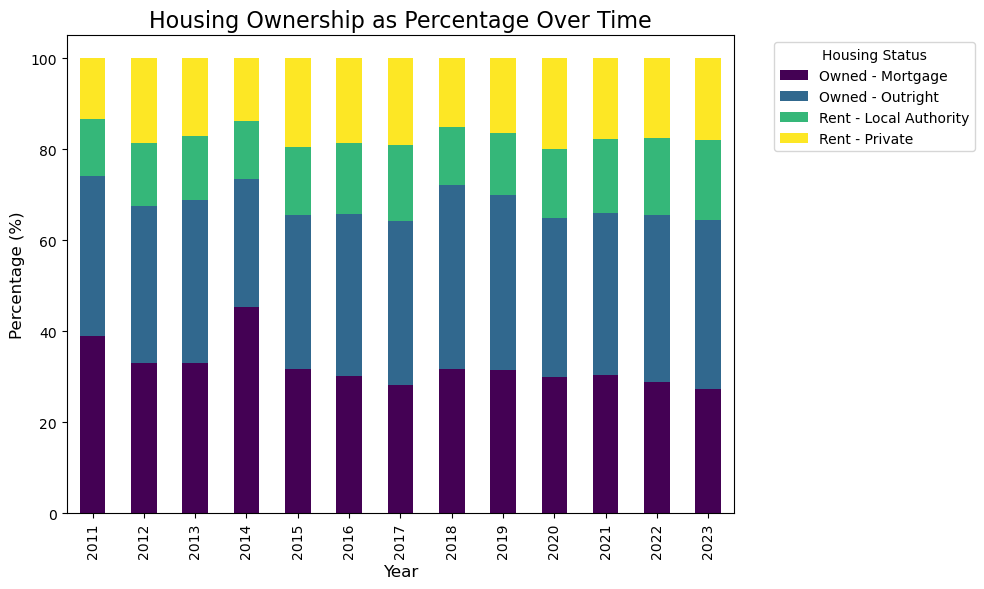

In [9]:
# Create a count of occurrences for each Housing_Status per Year
pivot_table = combined_df.groupby(['year', 'dhousing']).size().unstack(fill_value=0)

# Remove code 98 from the data
pivot_table.drop(columns=[98], inplace=True, errors='ignore')  # Drop column 98 if it exists

# Normalize the pivot table to percentages (row-wise)
percentage_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Relabel the columns for better readability
housing_labels = {
    1: "Owned - Mortgage",
    2: "Owned - Outright",
    3: "Rent - Local Authority",
    4: "Rent - Private"
}
percentage_table.rename(columns=housing_labels, inplace=True)

# Plotting the stacked bar chart
percentage_table.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6),
    colormap='viridis'
)

# Adding labels and title
plt.title('Housing Ownership as Percentage Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Housing Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
print(percentage_table)

dhousing  Owned - Mortgage  Owned - Outright  Rent - Local Authority  \
year                                                                   
2011             38.979592         35.102041               12.551020   
2012             33.062880         34.533469               13.691684   
2013             33.016304         35.716712               14.249321   
2014             45.303030         28.164983               12.811448   
2015             31.797545         33.680847               15.032790   
2016             30.252101         35.495798               15.512605   
2017             28.086316         36.032118               16.694547   
2018             31.744966         40.436242               12.718121   
2019             31.542173         38.346365               13.691565   
2020             30.023364         34.946595               15.136849   
2021             30.277824         35.601397               16.353352   
2022             28.904041         36.554133               16.88

## Income 

In [29]:
income_labels = {
    1: "Up to £4,499",
    2: "£4,500 - £6,499",
    3: "£6,500 - £7,499",
    4: "£7,500 - £9,499",
    5: "£9,500 - £11,499",
    6: "£11,500 - £13,499",
    7: "£13,500 - £15,499",
    8: "£15,500 - £17,499",
    9: "£17,500 - £24,999",
    10: "£25,000 - £29,999",
    11: "£30,000 - £39,999",
    12: "£40,000 - £49,999",
    13: "£50,000 - £74,999",
    14: "£75,000 - £99,999",
    15: "£100,000 or more",
    97: "Don't know",
    96: "Prefer not to state"
}

# Replace numerical codes with labels
combined_df['qincome-range'] = combined_df['qincome'].map(income_labels)

# Define midpoints for each income range
income_midpoints = {
    1: 2250,
    2: 5500,
    3: 7000,
    4: 8500,
    5: 10500,
    6: 12500,
    7: 14500,
    8: 16500,
    9: 21000,
    10: 27500,
    11: 35000,
    12: 45000,
    13: 62500,
    14: 87500,
    15: 100000,  # Lower bound for "£100,000 or more"
    96: None,  # Exclude "Prefer not to state"
    97: None   # Exclude "Don't know"
}

# Add a column for midpoint income values
combined_df['qincome-midpoint'] = combined_df['qincome'].map(income_midpoints)

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_5040/2561008459.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['qincome-midpoint'] = combined_df['qincome'].map(income_midpoints)


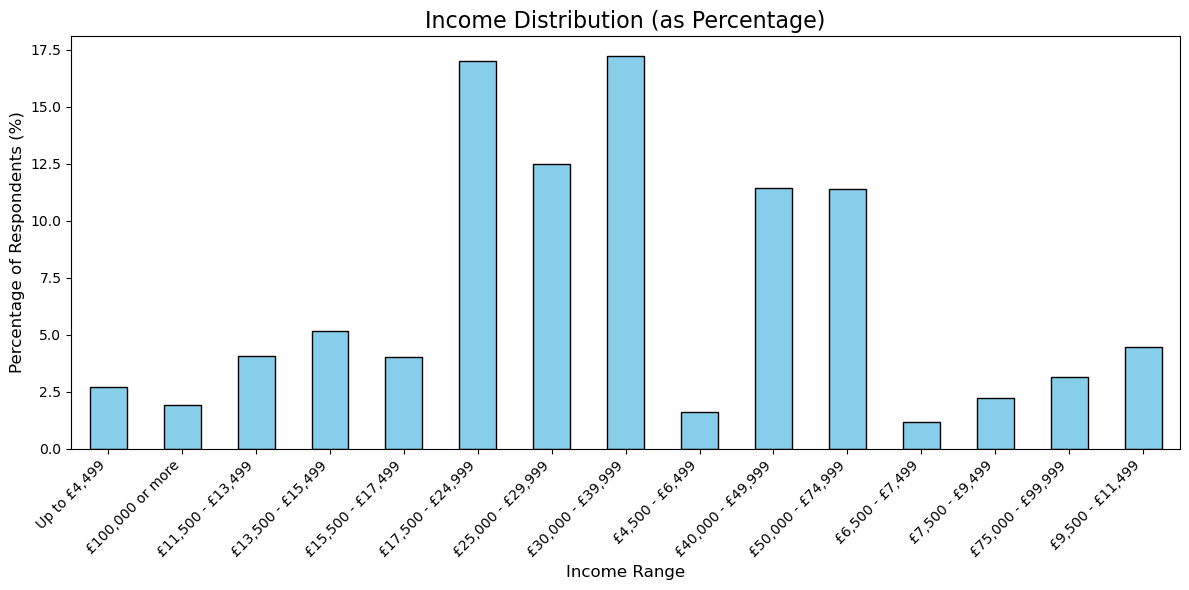

In [30]:
# Exclude non-informative responses
df_filtered = combined_df[~combined_df['qincome-range'].isin(["Don't know", "Prefer not to state"])]

# Calculate the percentage distribution
income_distribution = df_filtered['qincome-range'].value_counts(normalize=True) * 100

# Sort income categories for a logical order
income_distribution = income_distribution.sort_index()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
income_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Income Distribution (as Percentage)', fontsize=16)
plt.xlabel('Income Range', fontsize=12)
plt.ylabel('Percentage of Respondents (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

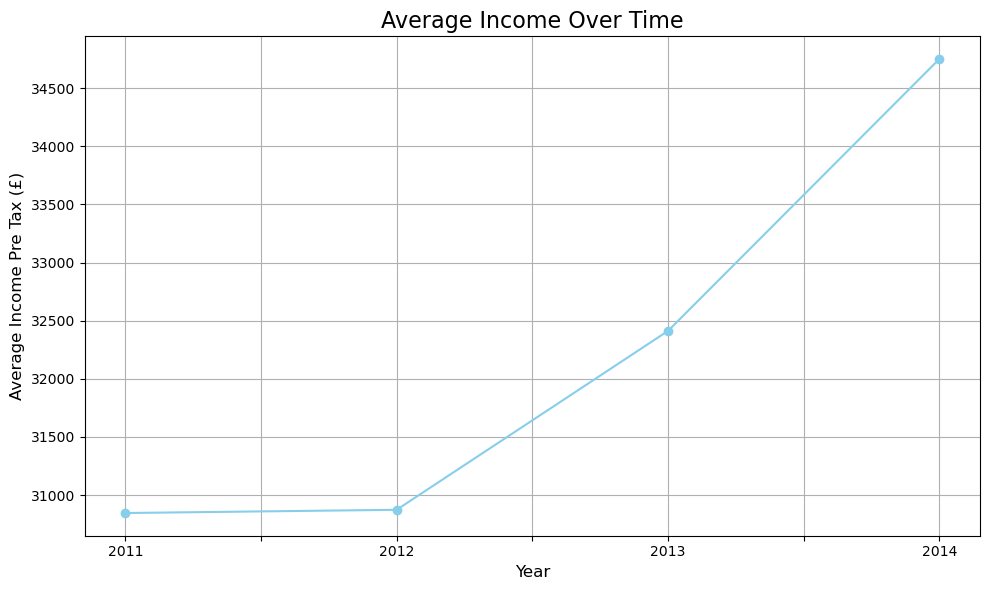

In [38]:
# Group by Year and calculate average income
average_income_per_year = df_filtered.groupby('year')['qincome-midpoint'].mean()

# Plot the trend over time
plt.figure(figsize=(10, 6))
average_income_per_year.plot(kind='line', marker='o', color='skyblue')
plt.title('Average Income Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Income Pre Tax (£)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_5040/3291534506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dhousing-labels'] = df_filtered['dhousing'].map(housing_labels)


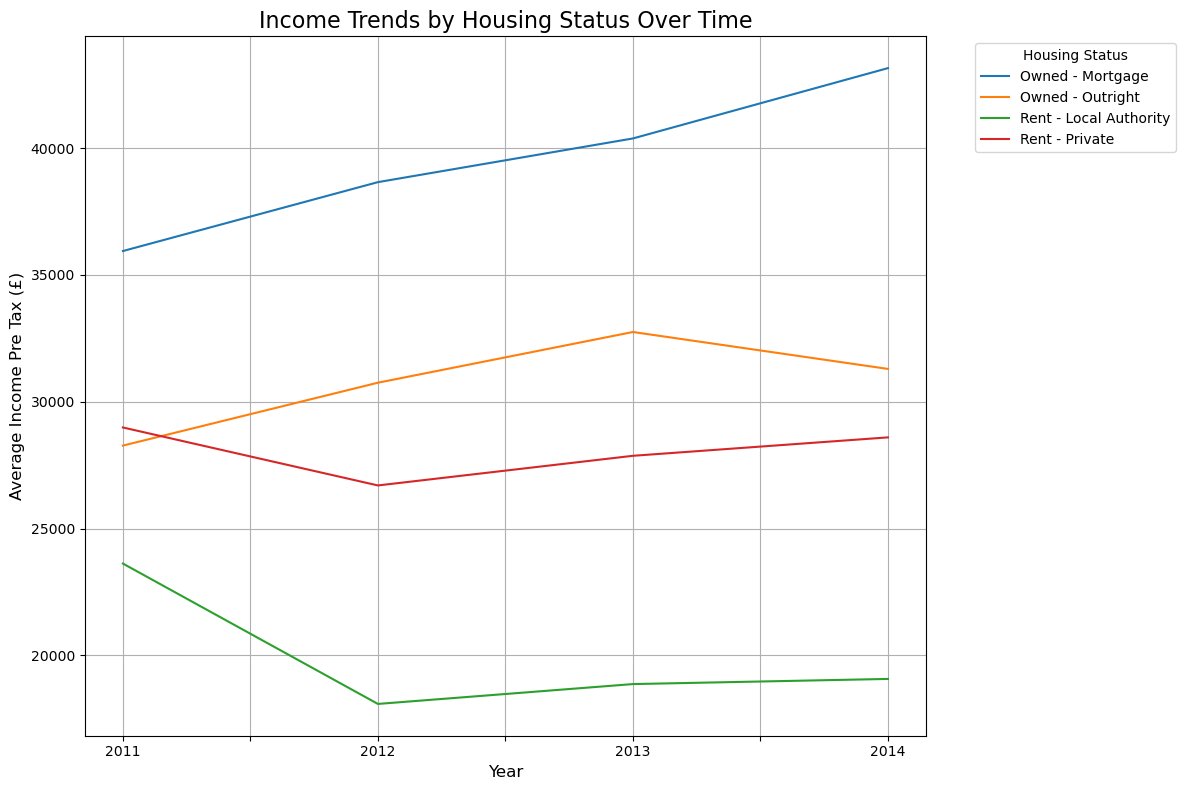

In [35]:
# Define the new housing labels
housing_labels = {
    1: "Owned - Mortgage",
    2: "Owned - Outright",
    3: "Rent - Local Authority",
    4: "Rent - Private"
}

# Map the new labels to the 'Housing_Status' column
df_filtered['dhousing-labels'] = df_filtered['dhousing'].map(housing_labels)

# Group by Year and Housing Status to calculate average income
income_trends_by_group = df_filtered.groupby(['year', 'dhousing-labels'])['qincome-midpoint'].mean().unstack()

# Plot income trends for each group
income_trends_by_group.plot(kind='line', figsize=(12, 8))
plt.title('Income Trends by Housing Status Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Income Pre Tax (£)', fontsize=12)
plt.legend(title='Housing Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()